## Homework 1: Applied Machine Learning

This assignment covers contents of the first three lectures.

The emphasis for this assignment would be on the following:
1. Data Visualization and Analysis
2. Linear Models for Regression and Classification
3. Support Vector Machines

In [1]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.svm import LinearSVC, SVC

## **Part 1: Data Visualization and Analysis**

Understanding data characteristics and patterns is crucial for building effective models. In this part, we will visualize and analyze the `insurance.csv` dataset.

<b>Note: Remember to label plot axes while plotting.</b>

In [3]:
# Load the dataset
insurance_df = pd.read_csv('insurance.csv')

**1.1 Create a bar chart to compare the average insurance charges by sex and region.**


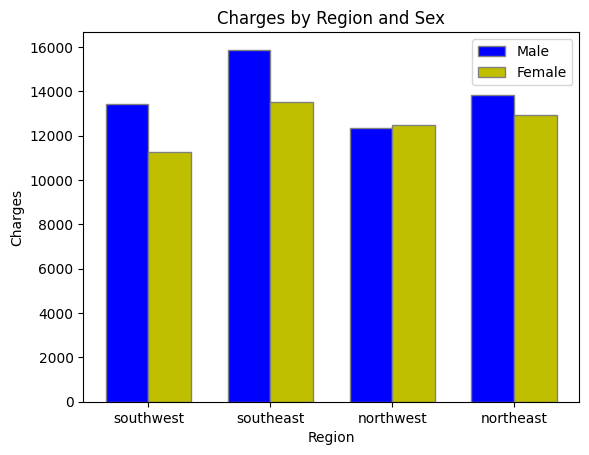

In [4]:
regions = insurance_df['region'].unique()

mean_charges_male = [insurance_df[(insurance_df['region'] == region) & (insurance_df['sex'] == 'male')]['charges'].mean() for region in regions]
mean_charges_female = [insurance_df[(insurance_df['region'] == region) & (insurance_df['sex'] == 'female')]['charges'].mean() for region in regions]

bar_width = 0.35

r1 = np.arange(len(regions))
r2 = [x + bar_width for x in r1]

plt.bar(r1, mean_charges_male, color='b', width=bar_width, edgecolor='grey', label='Male')
plt.bar(r2, mean_charges_female, color='y', width=bar_width, edgecolor='grey', label='Female')


plt.title('Charges by Region and Sex')
plt.xlabel('Region')
plt.ylabel('Charges')
plt.xticks([r + bar_width/2 for r in range(len(regions))], regions)

plt.legend()
plt.show()

The plot shows the average charges varies by region but it shows that the charges for female-identified individuals are lower than for male identified individuals in all regions.

**1.2 Plot a small multiple of bar charts to visualize the data distribution for the following categorical variables:**
1. **sex**
2. **region**
3. **children**
4. **smoker**

**Make subplots in the same graph**

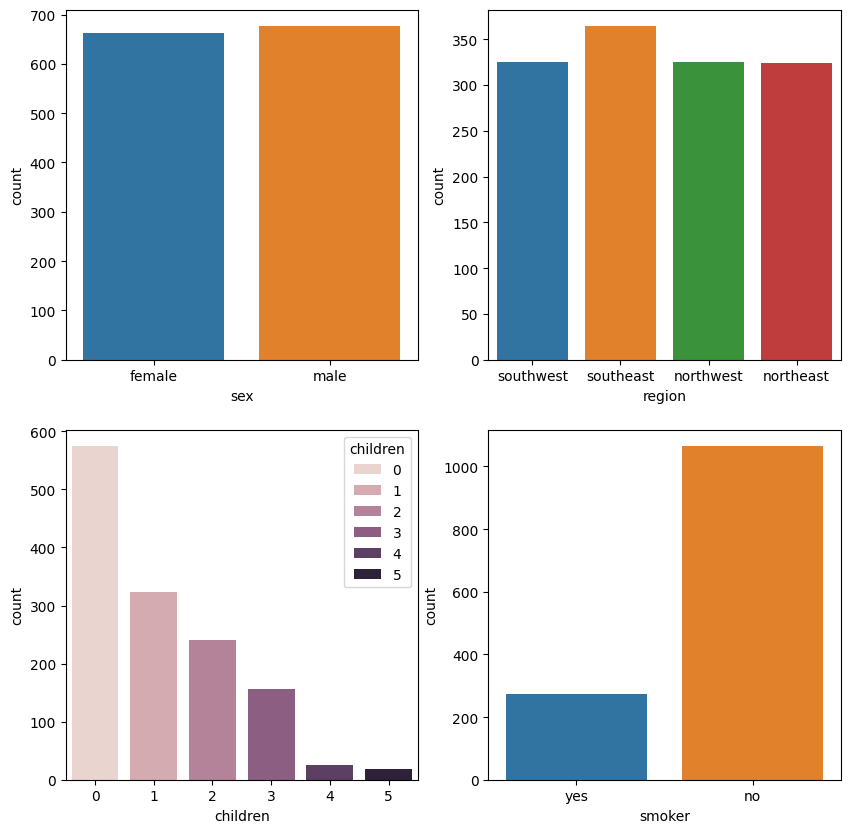

In [5]:
variables = ["sex",'region','children','smoker']
fig, ax = plt.subplots(2,2,figsize=(10,10))

for var, subplot in zip(variables, ax.flatten()):
    sns.countplot(x=var, data=insurance_df, ax=subplot,hue = var)

**1.3 Compare the insurance charges by age and smoker. Create a Scatter plot for age vs insurance charges categorize them by smoker type.**

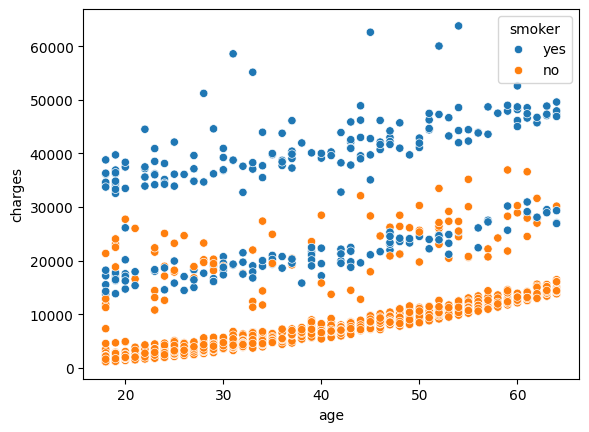

In [6]:
sns.scatterplot(x='age',y='charges',data=insurance_df,hue='smoker')
plt.show()

## **Part 2: Linear Models for Regression and Classification**

In this section, we will be implementing three linear models **linear regression, logistic regression, and SVM**.

### **2.1 Linear Regression**
We will now proceed with splitting the dataset and implementing linear regression to predict `insurance charges`.

In [7]:
# Split the dataset into features and labels
insurance_X = insurance_df.drop(columns=['charges'])
insurance_y = insurance_df['charges']

**2.1.1 Plot relationships between features (age, bmi, children, region) and the target variable `charges` as a small multiple of scatter plots.**
1. age
2. bmi
3. children
4. region

Make sure to label the axes.
<b></b>

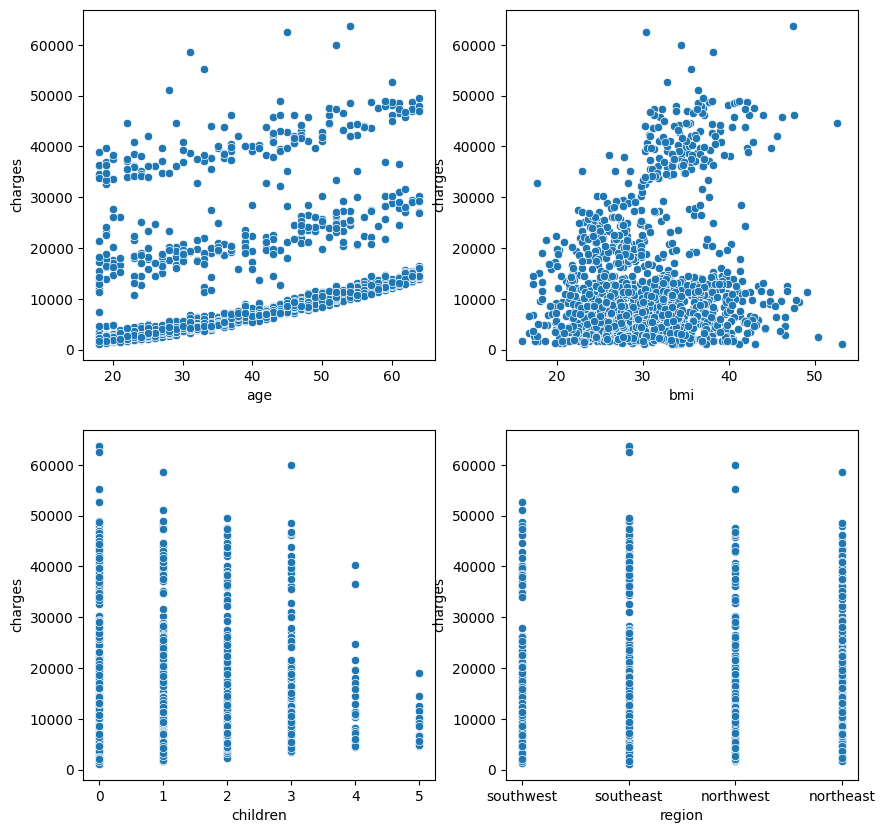

In [8]:
variables = ["age",'bmi','children','region']
fig, ax = plt.subplots(2,2,figsize=(10,10))

for var, subplot in zip(variables, ax.flatten()):
    sns.scatterplot(x=var, y ='charges', data=insurance_df, ax=subplot)

**2.1.2 From the visualizations above, do you think linear regression is a good model for this problem? Why and/or why not? Please explain.**


Linear regression could be a good model if we take all the categorical data into consideration - as some of the features shows linear relationship within certain clusters. If these cluster can be modeled using categorical features, then linear regression could work. Linear regression is good because we want to predict the final charges, which is a numerical value. However, it is important to note that these variables do not show a straightforward continuous relationship with the target variables. 

### **Data Preprocessing**

Before we can fit a linear regression model, several pre-processing steps should be applied to the dataset:

1. **Encode categorical features appropriately** (e.g., `sex`, `smoker`, `region`).
2. **Check for multicollinearity** by analyzing the correlation matrix and removing any highly collinear features.
3. **Split the dataset** into training (60%), validation (20%), and test (20%) sets.
4. **Standardize the feature matrices** (`X_train`, `X_val`, and `X_test`) to have zero mean and unit variance. Ensure that the standardization parameters (mean, variance) are learned from `X_train` and then applied to all sets to avoid information leakage.
5. **Add a column of ones** to `X_train`, `X_val`, and `X_test` for learning the bias term in the linear model.


**2.1.3 Encode the categorical variables of the Insurance dataset.**

In [9]:
### Code here   
from sklearn.compose import make_column_transformer


ohe_features=["sex",'smoker','region']
encoder = OneHotEncoder()

encoded_features = encoder.fit_transform(insurance_X[ohe_features])

encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(ohe_features))
insurance_X = insurance_X.drop(columns=ohe_features).reset_index(drop=True)
insurance_X = pd.concat([insurance_X, encoded_df], axis=1)


**2.1.4 Plot the correlation matrix, and check if there is high correlation between the given numerical features (Threshold >= 0.8). If yes, drop one from each pair of highly correlated features from the dataframe. It is fine if you do not find any highly correlated features. Why could this be necessary before proceeding further?**

<Axes: >

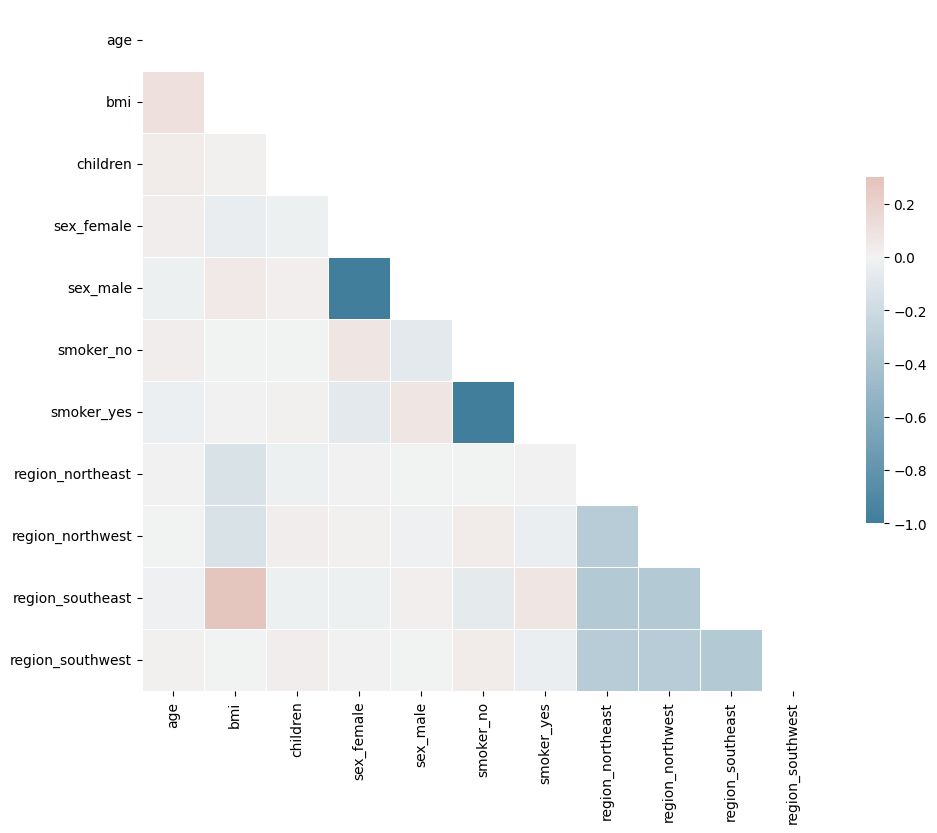

In [10]:

insurance_corr = insurance_X.corr()

mask = np.triu(np.ones_like(insurance_corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(insurance_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
insurance_X.drop(columns=['sex_female','smoker_no','region_northeast'], inplace=True)

We want to avoid multicolinearity because we are seeking a close formed solution, and you can not find the inverse of the X matrix if it is not full rank.

**2.1.5 Split the dataset into training (60%), validation (20%), and test (20%) sets.**

In [12]:
insurance_X_dev, insurance_X_test, insurance_y_dev, insurance_y_test = train_test_split(insurance_X, insurance_y, test_size=0.2, random_state=0)
insurance_X_train, insurance_X_val, insurance_y_train, insurance_y_val = train_test_split(insurance_X_dev, insurance_y_dev, test_size=0.25, random_state=0)

**2.1.6 Standardize the columns in the feature matrices.**

In [13]:
### Code here
numerical_features = ['age', 'bmi', 'children']

scaler = StandardScaler()
scaler.fit(insurance_X_train[numerical_features])

insurance_X_train[numerical_features] = scaler.transform(insurance_X_train[numerical_features])
insurance_X_val[numerical_features] = scaler.transform(insurance_X_val[numerical_features])
insurance_X_test[numerical_features] = scaler.transform(insurance_X_test[numerical_features])



In [14]:
# Adding a column of ones to include the bias term
columns = insurance_X_train.columns
insurance_X_train = np.hstack([np.ones((insurance_X_train.shape[0], 1)), insurance_X_train])
insurance_X_val = np.hstack([np.ones((insurance_X_val.shape[0], 1)), insurance_X_val])
insurance_X_test = np.hstack([np.ones((insurance_X_test.shape[0], 1)), insurance_X_test])

At the end of this pre-processing, you should have the following vectors and matrices:

- **insurance_X_train**: Training set feature matrix.
- **insurance_X_val**: Validation set feature matrix.
- **insurance_X_test**: Test set feature matrix.
- **insurance_y_train**: Training set labels (insurance charges).
- **insurance_y_val**: Validation set labels.
- **insurance_y_test**: Test set labels.


### Implement Linear Regression

Now that the data is preprocessed, we can implement a linear regression model, specifically Ridge Regression, which incorporates L2 regularization.

Given a feature matrix \( X \), a label vector \( y \), and a weight vector \( w \), the hypothesis function for linear regression is:

$$
y = X w
$$

The objective is to find the optimal weight vector \( w \) that minimizes the following loss function:



$$
\min_{w} \| X w - y \|^2_2 + \alpha \| w \|^2_2 \\
$$

Where:
-  $\| X w - y \|^2_2$ penalizes predictions that differ from actual labels.
- $\alpha \| w \|^2_2$ is the regularization term, helping reduce overfitting by penalizing large weights.
-  $\alpha$ is the regularization parameter.

The closed-form solution for Ridge Regression is given by the Normal Equations:

$$
w = (X^T X + \alpha I)^{-1} X^T y
$$





**2.1.7 Implement a `LinearRegression` class with `train` and `predict` methods**

We will now implement a custom `LinearRegression` class with L2 regularization (Ridge Regression).

**Note: You may NOT use sklearn for this implementation. You may, however, use `np.linalg.solve` to find the closed-form solution. It is highly recommended that you vectorize your code.**

In [15]:
class LinearRegression():
    '''
    Linear regression model with L2-regularization (i.e. ridge regression).

    Attributes
    ----------
    alpha: regularization parameter
    w: (n x 1) weight vector
    '''
    def __init__(self, alpha=0):
        self.alpha = alpha
        self.w = None

    def train(self, X, y):
        '''Trains model using ridge regression closed-form solution.
        Parameters:
        X : (m x n) feature matrix
        y: (m x 1) label vector
        '''
        if type(y) == pd.Series:
            y = y.values
        if type(X) == pd.DataFrame:
            X = X.values
        self.w = np.linalg.solve(X.T @ X + self.alpha * np.eye(X.shape[1]), X.T @ y)  
        

    def predict(self, X):
        '''Predicts on X using trained model.
        Parameters:
        X : (m x n) feature matrix
        Returns:
        y_pred: (m x 1) prediction vector
        '''
        y_predict = X @ self.w
        return y_predict


**2.1.8 Train, Evaluate, and Interpret Linear Regression Model**

**Train a linear regression model ($\alpha = 0$) on the insurance dataset. Make predictions and report the $R^2$ score on the training, validation, and test sets. Report the first 3 and last 3 predictions on the test set, along with the actual labels.**


In [16]:
def get_report(y_pred, y_test):
    """
    Report the first 3 and last 3 predictions on X_test,
    along with the actual labels in y_test.

    Returns:
        A dataframe with 6 rows comparing predictions and actuals.
    """
    preds = np.concatenate([y_pred[:3], y_pred[-3:]])
    actuals = np.concatenate([y_test[:3], y_test[-3:]])
    df_compare = pd.DataFrame({'Prediction': preds,
                               'Actual': actuals})
    df_compare['Position'] = [1, 2, 3, len(y_pred) - 2, len(y_pred) - 1, len(y_pred)]
    df_compare = df_compare.set_index('Position')
    return df_compare

In [17]:
model = LinearRegression()
model.train(insurance_X_train, insurance_y_train)
y_pred = model.predict(insurance_X_test)
get_report(y_pred, insurance_y_test)



,Prediction,Actual
Position,,
1,11351.075203,9724.53000
2,9700.882215,8547.69130
3,38235.614552,45702.02235
266,16352.480222,20709.02034
267,32989.621066,40932.42950
268,9542.694645,9500.57305


In [18]:

model.train(insurance_X_train, insurance_y_train)
y_train_pred = model.predict(insurance_X_train)
r2_train = r2_score(insurance_y_train, y_train_pred)
print(f"R^2 on training set is: {r2_train:.4f}")

y_val_pred = model.predict(insurance_X_val)
r2_val = r2_score(insurance_y_val, y_val_pred)
print(f"R^2 on validation set is: {r2_val:.4f}")

y_test_pred = model.predict(insurance_X_test)
r2_test = r2_score(insurance_y_test, y_test_pred)
print(f"R^2 on test set is: {r2_test:.4f}")

R^2 on training set is: 0.7410
R^2 on validation set is: 0.7242
R^2 on test set is: 0.7998


**2.1.9 Use the mean of the training labels (insurance_y_train) as the prediction for all instances. Report the $R^2$ on the training, validation, and test sets using this baseline.**

>This is a common baseline used in regression problems and tells you if your model is any good. Your linear regression $R^2$ should be much higher than these baseline $R^2$.

In [19]:
### Code here
y_pred_baseline = np.mean(insurance_y_train)
training_r2 = r2_score(insurance_y_train, np.full(insurance_y_train.shape, y_pred_baseline))
validation_r2 = r2_score(insurance_y_val, np.full(insurance_y_val.shape, y_pred_baseline))
test_r2 = r2_score(insurance_y_test, np.full(insurance_y_test.shape, y_pred_baseline))
print(f"Baseline R^2: Training = {training_r2:.4f}, Validation = {validation_r2:.4f}, Test = {test_r2:.4f}")

Baseline R^2: Training = 0.0000, Validation = -0.0008, Test = -0.0004


**2.1.10 Interpret your model trained on the insurance dataset using a bar chart of the model weights. Make sure to label the bars (x-axis) and don't forget the bias term!**

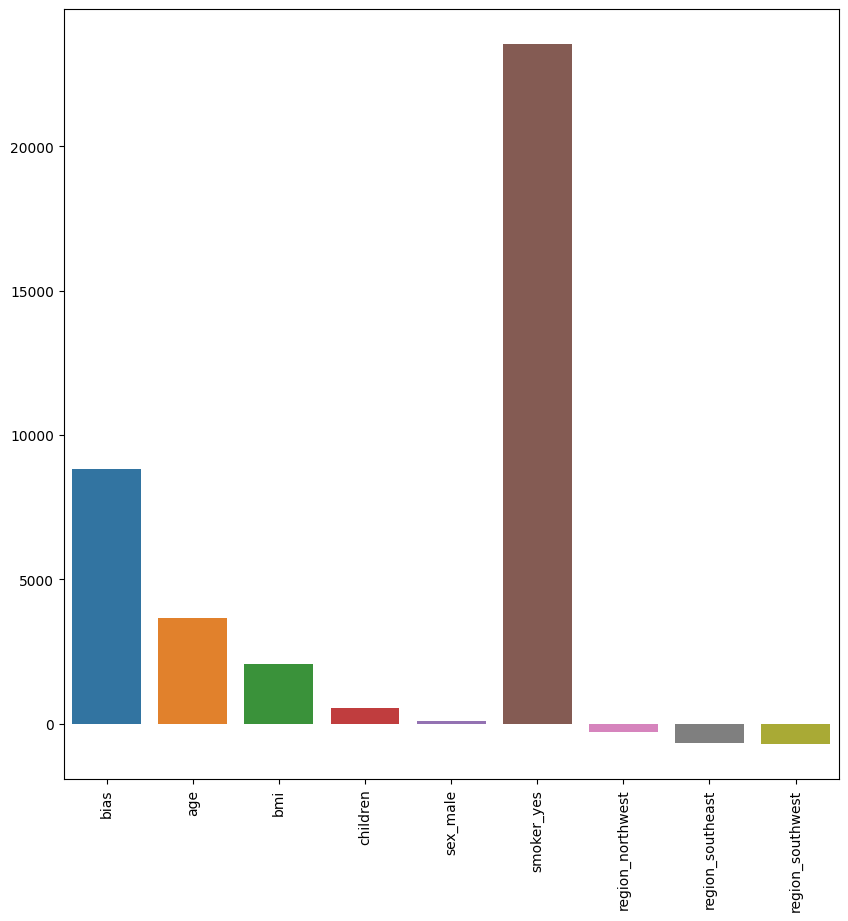

In [20]:
weights = model.w
names = ['bias'] + list(columns)

fig = plt.figure(figsize=(10,10))
ax = sns.barplot(x=names,y = weights, hue = names)
ax.tick_params(axis='x', rotation=90)

**2.1.11 According to your model, which features are the greatest contributors to insurance charges?**

Smoker status and the age are the greatest contributor to insurance charges

### **Hyperparameter Tuning ($\alpha$)**

Now, let's tune the $\alpha$ regularization parameter for ridge regression on the insurance dataset.

**2.1.12 Sweep out values for $\alpha$ using `alphas = np.logspace(-5, 1, 20)`. Perform a grid search over these $\alpha$ values, recording the training and validation $R^2$ for each $\alpha$. Plot the results with a log scale for $\alpha$. A simple grid search is fine, no need for k-fold cross validation. Plot the training and validation $R^2$ as a function of $\alpha$ on a single figure. Make sure to label the axes and the training and validation $R^2$ curves. Use a log scale for the x-axis.****

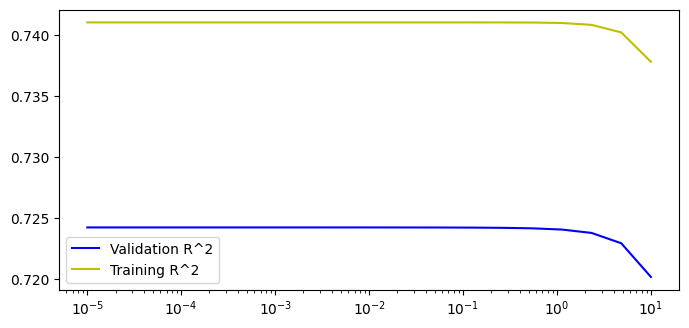

In [21]:
### Code here

alphas= np.logspace(-5,1,20)

val_scores = []
train_scores = []
for alpha in alphas:
    model = LinearRegression(alpha=alpha)
    model.train(insurance_X_train, insurance_y_train)
    y_pred_train = model.predict(insurance_X_train)
    y_pred_val = model.predict(insurance_X_val)
    validation_r2 = r2_score(insurance_y_val, y_pred_val)
    train_r2 = r2_score(insurance_y_train, y_pred_train)
    val_scores.append(validation_r2)
    train_scores.append(train_r2)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(2, 1, 1)
plt.plot(alphas, val_scores, label='Validation R^2',color = 'b')
plt.plot(alphas, train_scores, label='Training R^2',color='y')
ax.set_xscale('log')
plt.legend()
plt.show()


**2.1.13 Explain your plot above. How do training and validation $R^2$ behave with increasing $\alpha$?**

The model's performance decreases while increasing alpha


### 2.2 Logistic Regression

**2.2.1 Load the dataset, the dataset to be used is loan_data.csv**

In [22]:
loan_data_df = pd.read_csv('loan_data.csv')


In [23]:
loan_data_df = loan_data_df.drop(columns=['Loan_ID'])

**2.2.2 Are there any missing values in the dataset? If so, what is the best way to deal with it and why?**

In [24]:
print("There are %.2f%% rows with missing values." % (len(loan_data_df[loan_data_df.isnull().any(axis=1)]) / len(loan_data_df) * 100))

There are 21.82% rows with missing values.


There are a lot of missing data - about 22% rows have them. We can't simply drop the rows because that will greatly reduce our dataset size. For the columns with missing values, I want to examine the distribution of the data. If the distribution centers around some mode, I will use the mode to backfill the missing data.

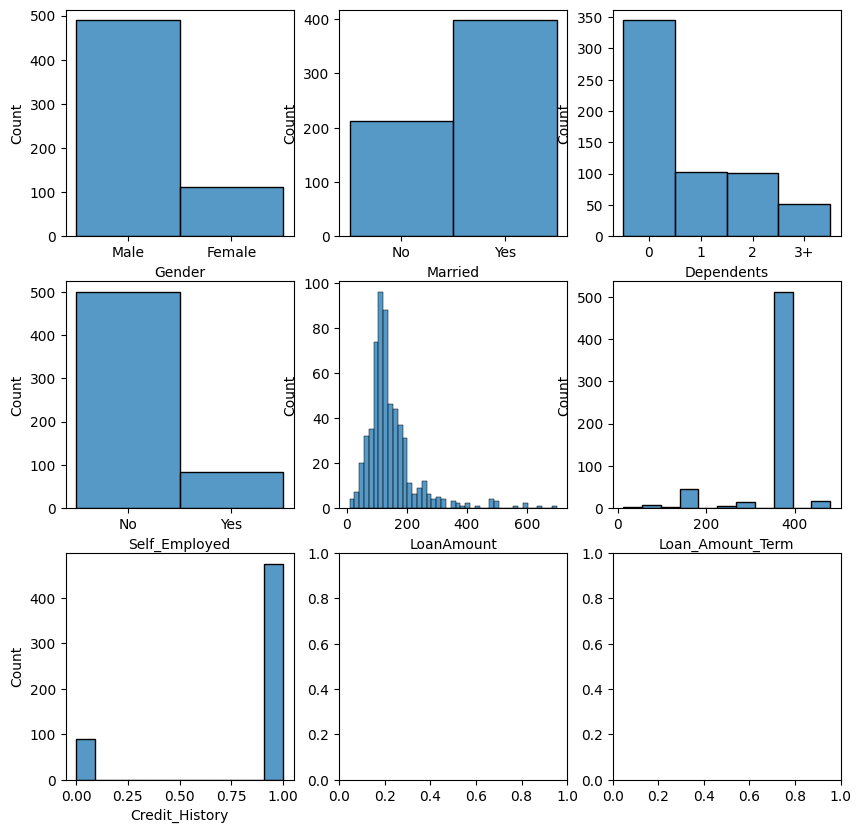

In [25]:
columns_with_missing_values = loan_data_df.columns[loan_data_df.isnull().any()]
fig, ax = plt.subplots(3,3,figsize=(10,10))
for var, subplot in zip(columns_with_missing_values, ax.flatten()):
    sns.histplot(x=var, data=loan_data_df, ax=subplot)
    

In [26]:
columns_to_back_fill = ["Gender",'Dependents','Married','Self_Employed','Credit_History','Loan_Amount_Term']
for column in columns_to_back_fill:
    loan_data_df[column] = loan_data_df[column].fillna(loan_data_df[column].mode()[0])
    

loan_data_df['LoanAmount'] = loan_data_df[column].fillna(loan_data_df[column].median())

print("Now there are %.2f%% rows with missing values. We will drop these rows." % (len(loan_data_df[loan_data_df.isnull().any(axis=1)]) / len(loan_data_df) * 100))
loan_data_df = loan_data_df.dropna(axis=0)

Now there are 0.00% rows with missing values. We will drop these rows.


**2.2.3 Encode the categorical variables.**

In [27]:
ohe_features=["Education",'Gender','Married','Dependents','Self_Employed','Property_Area','Credit_History']

loan_data_X = loan_data_df.drop(columns=['Loan_Status'])
loan_data_X = pd.get_dummies(loan_data_X, columns=ohe_features,drop_first=True)

loan_data_y = loan_data_df['Loan_Status']

features = loan_data_X.columns

**2.2.4 Do you think that the distribution of labels is balanced? Why/why not? Hint: Find the probability of the different categories.**

In [28]:
p_yes = len(loan_data_df[loan_data_df['Loan_Status'] == 'Y']) / len(loan_data_df)
p_no = 1 - p_yes

print("the probability of loan status being yes is %.2f%% and being no is %.2f%%, which is very loopsised to yes" % (p_yes,p_no))


the probability of loan status being yes is 0.69% and being no is 0.31%, which is very loopsised to yes


the probability of loan status being yes is 0.69% and being no is 0.31%, which is very loopsised to yes

**2.2.5 Plot the correlation matrix (first separate features and Y variable), and check if there is high correlation between the given numerical features (Threshold >=0.9). If yes, drop those highly correlated features from the dataframe.**

<Axes: >

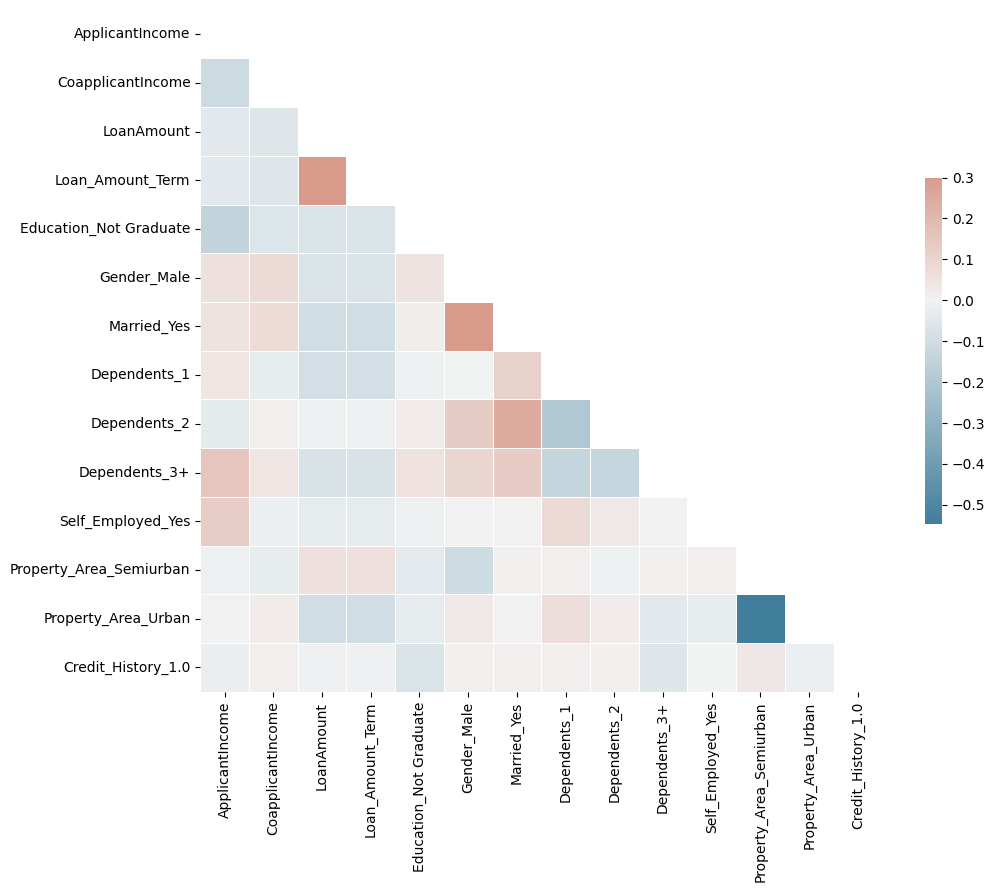

In [29]:
loan_corr = loan_data_X.corr()

mask = np.triu(np.ones_like(loan_corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(loan_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**2.2.6 Apply the following pre-processing steps:**

1. Convert the label from a Pandas series to a Numpy (m x 1) vector. If you don't do this, it may cause problems when implementing the logistic regression model.
2. Split the dataset into training (60%), validation (20%), and test (20%) sets.
3. Standardize the columns in the feature matrices. To avoid information leakage, learn the standardization parameters from training, and then apply training, validation and test dataset.
4. Add a column of ones to the feature matrices of train, validation and test dataset. This is a common trick so that we can learn a coefficient for the bias term of a linear model.

In [30]:
loan_data_y = np.where(loan_data_y == 'Y', 1, 0)
loan_data_y=loan_data_y.reshape(-1,1)

loan_X_dev, loan_X_test, loan_y_dev, loan_y_test = train_test_split(loan_data_X, loan_data_y, test_size=0.2, random_state=0)
loan_X_train, loan_X_val, loan_y_train, loan_y_val = train_test_split(loan_X_dev, loan_y_dev, test_size=0.25, random_state=0)

numerical_features= ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']
preprocessor = make_column_transformer((StandardScaler(), numerical_features),remainder='passthrough')
preprocessor.fit(loan_X_train)

loan_X_train = preprocessor.transform(loan_X_train)
loan_X_val = preprocessor.transform(loan_X_val)
loan_X_test = preprocessor.transform(loan_X_test)

loan_X_train = np.hstack([np.ones((loan_X_train.shape[0], 1)), loan_X_train])
loan_X_val = np.hstack([np.ones((loan_X_val.shape[0], 1)), loan_X_val])
loan_X_test = np.hstack([np.ones((loan_X_test.shape[0], 1)), loan_X_test])


### Implement Logisitc Regression

We will now implement logistic regression with L2 regularization. Given an (m x n) feature matrix $X$, an (m x 1) label vector $y$, and an (n x 1) weight vector $w$, the hypothesis function for logistic regression is:

$$
y = \sigma(X w)
$$

where $\sigma(x) = \frac{1}{1 + e^{-x}}$, i.e. the sigmoid function. This function scales the prediction to be a probability between 0 and 1, and can then be thresholded to get a discrete class prediction.

Just as with linear regression, our objective in logistic regression is to learn the weights $𝑤$ which best fit the data. For L2-regularized logistic regression, we find an optimal $w$ to minimize the following loss function:

$$
\min_{w} \ -y^T \ \text{log}(\sigma(Xw)) \ - \  (\mathbf{1} - y)^T \ \text{log}(\mathbf{1} - \sigma(Xw)) \ + \ \alpha \| w \|^2_2 \\
$$

Unlike linear regression, however, logistic regression has no closed-form solution for the optimal $w$. So, we will use gradient descent to find the optimal $w$. The (n x 1) gradient vector $g$ for the loss function above is:

$$
g = X^T \Big(\sigma(Xw) - y\Big) + 2 \alpha w
$$

Below is pseudocode for gradient descent to find the optimal $w$. You should first initialize $w$ (e.g. to a (n x 1) zero vector). Then, for some number of epochs $t$, you should update $w$ with $w - \eta g $, where $\eta$ is the learning rate and $g$ is the gradient. You can learn more about gradient descent [here](https://www.coursera.org/lecture/machine-learning/gradient-descent-8SpIM).

> $w = \mathbf{0}$
>
> $\text{for } i = 1, 2, ..., t$
>
> $\quad \quad w = w - \eta g $


**A LogisticRegression class with five methods: train, predict, calculate_loss, calculate_gradient, and calculate_sigmoid has been implemented for you below.**

In [31]:
class LogisticRegression():
    '''
    Logistic regression model with L2 regularization.

    Attributes
    ----------
    alpha: regularization parameter
    t: number of epochs to run gradient descent
    eta: learning rate for gradient descent
    w: (n x 1) weight vector
    '''

    def __init__(self, alpha=0, t=100, eta=1e-3):
        self.alpha = alpha
        self.t = t
        self.eta = eta
        self.w = None

    def train(self, X, y):
        '''Trains logistic regression model using gradient descent
        (sets w to its optimal value).

        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector

        Returns
        -------
        losses: (t x 1) vector of losses at each epoch of gradient descent
        '''

        loss = list()
        self.w = np.zeros((X.shape[1],1))
        for i in range(self.t):
            self.w = self.w - (self.eta * self.calculate_gradient(X, y))
            loss.append(self.calculate_loss(X, y))
        return loss

    def predict(self, X):
        '''Predicts on X using trained model. Make sure to threshold
        the predicted probability to return a 0 or 1 prediction.

        Parameters
        ----------
        X : (m x n) feature matrix

        Returns
        -------
        y_pred: (m x 1) 0/1 prediction vector
        '''
        y_pred = self.calculate_sigmoid(X.dot(self.w))
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        return y_pred

    def calculate_loss(self, X, y):
        '''Calculates the logistic regression loss using X, y, w,
        and alpha. Useful as a helper function for train().

        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector

        Returns
        -------
        loss: (scalar) logistic regression loss
        '''
        loss= -y.T.dot(np.log(self.calculate_sigmoid(X.dot(self.w)))) - (1-y).T.dot(np.log(1-self.calculate_sigmoid(X.dot(self.w)))) + self.alpha*np.linalg.norm(self.w, ord=2)**2
        return loss.item()

    def calculate_gradient(self, X, y):
        '''Calculates the gradient of the logistic regression loss
        using X, y, w, and alpha. Useful as a helper function
        for train().

        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector

        Returns
        -------
        gradient: (n x 1) gradient vector for logistic regression loss
        '''
        return X.T.dot(self.calculate_sigmoid( X.dot(self.w)) - y) + 2*self.alpha*self.w


    def calculate_sigmoid(self, x):
        '''Calculates the sigmoid function on each element in vector x.
        Useful as a helper function for predict(), calculate_loss(),
        and calculate_gradient().

        Parameters
        ----------
        x: (m x 1) vector

        Returns
        -------
        sigmoid_x: (m x 1) vector of sigmoid on each element in x
        '''
        return (1)/(1 + np.exp(-x.astype('float')))
    

**2.2.7 Plot Loss over Epoch and Search the space randomly to find best hyperparameters.**

i) Using your implementation above, train a logistic regression model **(alpha=0, t=100, eta=1e-3)** on the loan training data. Plot the training loss over epochs. Make sure to label your axes. You should see the loss decreasing and start to converge.

ii) Using **alpha between (0,1), eta between(0, 0.001) and t between (0, 100)**, find the best hyperparameters for LogisticRegression. You can randomly search the space 20 times to find the best hyperparameters.

iii) Compare accuracy on the test dataset for both the scenarios.

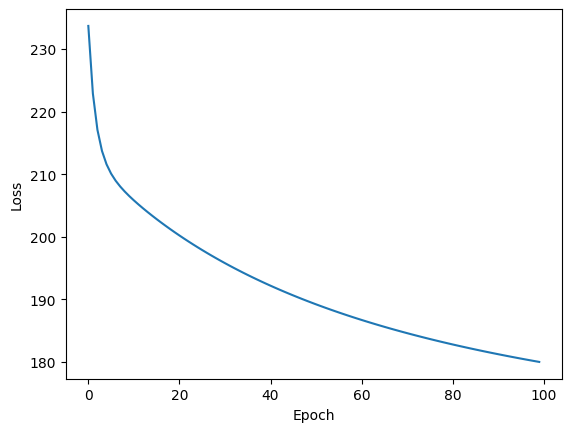

In [32]:
### Code here
model = LogisticRegression(alpha=0, t=100, eta=1e-3)
epoch = np.array(list(range(100)))
loan_X_train= loan_X_train.astype('float')
loss = model.train(loan_X_train, loan_y_train)

fig = sns.lineplot(x=epoch, y=loss)
fig.set(xlabel='Epoch', ylabel='Loss')
plt.show()

In [33]:
val_scores = []
alpha_random = np.random.sample(20)
eta_random = np.random.sample(20)*0.001
t_random = np.random.randint(0,100,20)

for alpha in alpha_random:
    for eta in eta_random:
        for t in t_random:  
            model = LogisticRegression(alpha=alpha, t= int(t), eta=eta)
            model.train(loan_X_train, loan_y_train)
            y_pred = model.predict(loan_X_val)
            val_score = r2_score(loan_y_val, y_pred)
            val_scores.append((val_score, (alpha, eta, t)))          

In [34]:
best_params = max(val_scores, key=lambda x: x[0])[1]
print(f"Best hyperparameters: alpha={best_params[0]}, eta={best_params[1]}, t={best_params[2]}")


Best hyperparameters: alpha=0.9485752178339437, eta=0.0007549574581000166, t=98


In [35]:
model_scenario_1 = LogisticRegression(alpha=0, t=100, eta=1e-3)
model_scenario_2= LogisticRegression(alpha=best_params[0], t=best_params[2], eta=best_params[1])
model_scenario_1.train(loan_X_train, loan_y_train)
model_scenario_2.train(loan_X_train, loan_y_train)

y_pred_scenario_1 = model_scenario_1.predict(loan_X_test)
y_pred_scenario_2 = model_scenario_2.predict(loan_X_test)

print("Scenario 1 R^2: %.3f and Scenario 2 R^2: %.3f" % (r2_score(loan_y_test, y_pred_scenario_1), r2_score(loan_y_test, y_pred_scenario_2)))


Scenario 1 R^2: 0.006 and Scenario 2 R^2: 0.047


### Feature Importance

**2.2.8 Interpret your trained model using a bar chart of the model weights. Make sure to label the bars (x-axis) and don't forget the bias term!**

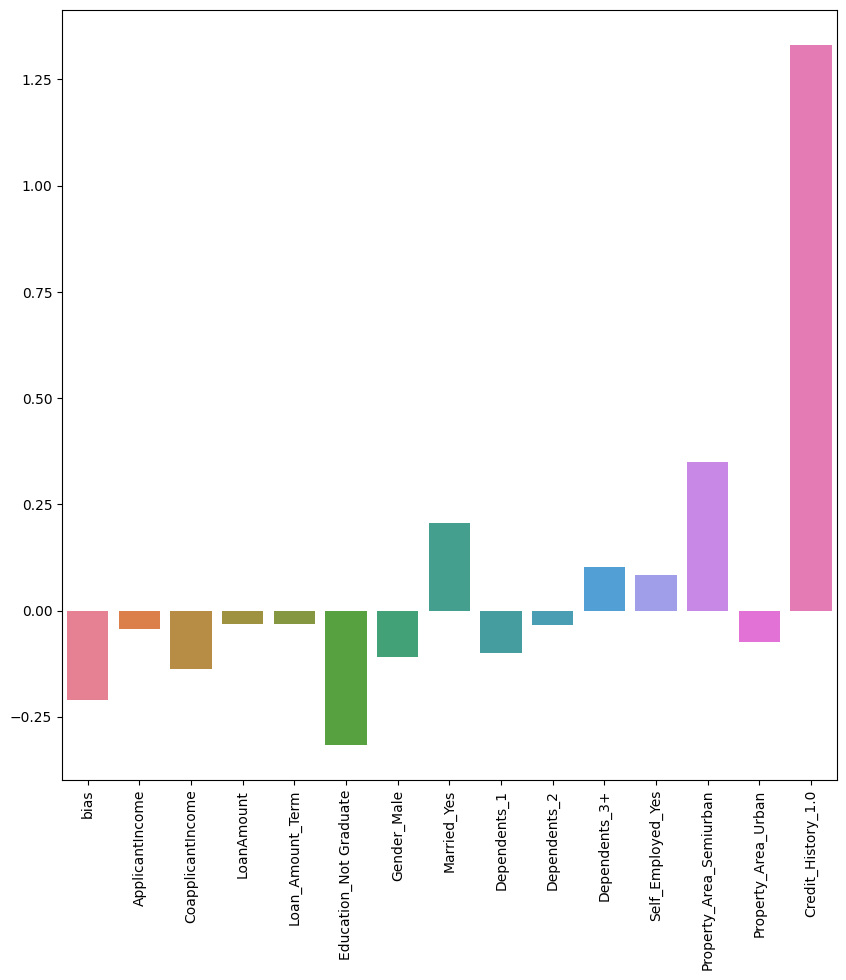

In [36]:
weights = model_scenario_2.w.reshape(-1)
feature_names = ['bias'] + list(features)

fig = plt.figure(figsize=(10,10))
ax = sns.barplot(x=feature_names,y = weights, hue = feature_names)
ax.tick_params(axis='x', rotation=90)


No credit history severly negatively impacts the loan decision. Aside from credit history, other factors can impact loan decisions include property area. Semi-urban property owners are more likely to obtain a positive loan decision. Loan applicants with "graduate" education label are more likely to obtain a positive loan decision 


### 2.3 Support Vector Machines

In this part, we will be using support vector machines for classification on the loan dataset.

### Train Primal SVM
**2.3.1 Train a primal SVM (with default parameters) on the loan dataset. Make predictions and report the accuracy on the training, validation, and test sets.**

In [37]:
primal_svm_model = LinearSVC(dual=False)
primal_svm_model.fit(loan_X_train, loan_y_train.reshape(-1))
primal_y_pred_train = primal_svm_model.predict(loan_X_train)
primal_y_pred_val = primal_svm_model.predict(loan_X_val)
primal_y_pred_test = primal_svm_model.predict(loan_X_test)

print("Primal SVM R^2 for training data: %.3f, for validation data %.3f, for test data %.3f" % (r2_score(loan_y_train, primal_y_pred_train ), r2_score(loan_y_val, primal_y_pred_val), r2_score(loan_y_test, primal_y_pred_test)))


Primal SVM R^2 for training data: 0.122, for validation data 0.062, for test data 0.172


### Train Dual SVM
**2.3.2 Train a dual SVM (with default parameters) on the heart disease dataset. Make predictions and report the accuracy on the training, validation, and test sets.**

In [38]:
from sklearn.datasets import load_iris


dual_svm_model = SVC(kernel='linear')
dual_svm_model.fit(loan_X_train, loan_y_train.reshape(-1))
dual_y_pred_train = dual_svm_model.predict(loan_X_train)
dual_y_pred_val = dual_svm_model.predict(loan_X_val)
dual_y_pred_test = dual_svm_model.predict(loan_X_test)

print("Dual SVM R^2 for training data: %.3f, for validation data %.3f, for test data %.3f" % (r2_score(loan_y_train, dual_y_pred_train ), r2_score(loan_y_val, dual_y_pred_val), r2_score(loan_y_test, dual_y_pred_test)))


Dual SVM R^2 for training data: 0.109, for validation data 0.062, for test data 0.130
